# Minimal end-to-end causal analysis with ```cause2e```
This notebook shows a minimal example of how ```cause2e``` can be used as a standalone package for end-to-end causal analysis. It illustrates how we can proceed in stringing together many causal techniques that have previously required fitting together various algorithms from separate sources with unclear interfaces. Additionally, the numerous techniques have been packed into only two easy-to-use functions for causal discovery and causal estimation. Hopefully, you will find this notebook helpful in guiding you through the process of setting up your own causal analyses for custom problems. The overall structure should always be the same regardless of the application domain. For more advanced features, check out the other notebooks.

### Imports
By the end of this notebook, you will probably be pleasantly surprised by the fact that we did not have to import lots of different packages to perform a full causal analysis consisting of different subtasks.

In [16]:
import os
from cause2e import path_mgr, knowledge, discovery

## Set up paths to data and output directories
This step is conveniently handled by the ```PathManager``` class, which avoids having to wrestle with paths throughout the multistep causal analysis. If we want to perform the analysis in a directory ```'dirname'``` that contains ```'dirname/data'``` and ```'dirname/output'``` as subdirectories, we can also use ```PathManagerQuick``` for an even easier setup. The ```experiment_name``` argument is used for generating output files with meaningful names, in case we want to study multiple scenarios (e.g. with varying model parameters).

For this analysis, we use the sprinkler dataset. Unfortunately, there are still some problems to be sorted out with categorical data in the estimation step, but continuous and discrete data work fine. Therefore, we use a version of the dataset where only the seasons ```'Spring'``` and ```'Summer'``` are present, such that we can replace these values by 0 and 1.

In [17]:
cwd = os.getcwd()
wd = os.path.dirname(cwd)
paths = path_mgr.PathManagerQuick(experiment_name='sprinkler',
                                  data_name='sprinkler.csv',
                                  directory=wd
                                  )

## Learn the causal graph from data and domain knowledge
Model-based causal inference leverages qualitative knowledge about pairwise causal connections to obtain unbiased estimates of quantitative causal effects. The qualitative knowledge is encoded in the causal graph, so we must recover this graph before we can start actually estimating the desired effects. For learning the graph from data and domain knowledge, we use the ```StructureLearner``` class.

In [18]:
learner = discovery.StructureLearner(paths)

### Read the data
The ```StructureLearner``` has reading methods for csv and parquet files.

In [19]:
learner.read_csv(index_col=0)

The first step in the analysis should be an assessment of which variables we are dealing with. In the sprinkler dataset, each sample tells us 
- the current season
- whether it is raining
- whether our lawn sprinkler is activated
- whether our lawn is slippery
- whether our lawn is wet.

In [20]:
learner.variables

{'Rain', 'Season', 'Slippery', 'Sprinkler', 'Wet'}

### Preprocess the data
As mentioned above, currently there are problems in the estimation step with categorical data, so we use this occasion to showcase ```cause2e```'s built-in preprocessing functionalities. We define a function that replaces instances of ```'Summer'``` by 1, and instances of ```'Spring'``` by 0. Afterwards we apply it to our data and throw out the categorical ```'Season'``` column. For more preprocessing options, check out the pertaining notebook.

In [21]:
def is_summer(data, col_name):
    return (data[col_name] == 'Summer').apply(int)

learner.combine_variables(name='Season_binary', func=is_summer, input_cols=['Season'], keep_old=False)

It necessary to communicate to the ```StructureLearner``` if the variables are discrete, continuous, or both. We check how many unique values each variable takes on in our sample and deduce that all variables are discrete.

In [22]:
learner.data.nunique()

Sprinkler        2
Rain             2
Wet              2
Slippery         2
Season_binary    2
dtype: int64

This information is passed to the ```StructureLearner``` by indicating the exact sets of discrete and continuous variables.

In [23]:
learner.discrete = learner.variables
learner.continuous = set()

### Provide domain knowledge
Humans can often infer parts of the causal graph from domain knowledge. The nodes are always just the variables in the data, so the problem of finding the right graph comes down to selecting the right edges between them. 

As a reminder: The correct causal graph has an edge from variable A to variable B if and only if variable A directly influences variable B (changing the value of variable A changes the value of variable B if we keep all other variables fixed).

There are three ways of passing domain knowledge for the graph search:
- Indicate which edges must be present in the causal graph.
- Indicate which edges must not be present in the causal graph.
- Indicate a temporal order in which the variables have been created. This is then used to generate forbidden edges, since the future can never influence the past.

In this example, we use the ```knowledge.EdgeCreator``` to prescribe that
- no variables are direct causes of the season,
- the lawn being slippery is not a direct cause of any other variable
- turning the sprinkler on or off directly affects the wetness of the lawn,
- turning the sprinkler on or off does not directly affect the weather.

In [24]:
edge_creator = knowledge.EdgeCreator()
edge_creator.forbid_edges_from_groups({'Season_binary'}, incoming=learner.variables)
edge_creator.forbid_edges_from_groups({'Slippery'}, outgoing=learner.variables)
edge_creator.require_edge('Sprinkler', 'Wet')
edge_creator.forbid_edge('Sprinkler', 'Rain')

There is a fourth way of passing knowledge which is not used in learning the graph, but in validating the quantitative estimates resulting from our end-to-end causal analysis. We often know beforehand what some of the quantitative effects should look like, e.g.
- turning the sprinkler on should have a positive overall effect (-> average treatment effect; read below if you are not familiar with types of causal effects) on the lawn being wet and 
- making the lawn wet should have a positive overall effect on the lawn being slippery.

Instead of checking manually at the end if our expectations have been met, we can automate this validation by using the ```knowledge.ValidationCreator```. For instructiveness, we also add two more validations that should fail: 
- the sprinkler has a negative natural direct effect on the weather and
- the natural indirect effect of the lawn being slippery on the season is between 0.2 and 0.4 (remember to normalize your data before such a validation if they are not measured on the same scale).

In [25]:
validation_creator = knowledge.ValidationCreator()
validation_creator.add_expected_effect(('Sprinkler', 'Wet', 'nonparametric-ate'), ('greater', 0))
validation_creator.add_expected_effect(('Wet', 'Slippery', 'nonparametric-ate'), ('greater', 0))
validation_creator.add_expected_effect(('Sprinkler', 'Rain', 'nonparametric-nde'), ('less', 0))
validation_creator.add_expected_effect(('Slippery', 'Season_binary', 'nonparametric-nie'), ('between', 0.2, 0.4))

We pass the knowledge to the ```StructureLearner``` and check if it has been correctly received.

Showing knowledge for graph search.

Causal graph constructed from domain knowledge:
(Edges required by domain knowledge in red, remaining allowed edges dotted)



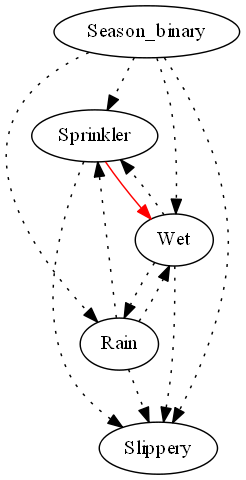

Required edges:
('Sprinkler', 'Wet')
--------------------
Forbidden edges:
('Wet', 'Season_binary')
('Slippery', 'Season_binary')
('Rain', 'Season_binary')
('Slippery', 'Slippery')
('Slippery', 'Wet')
('Slippery', 'Sprinkler')
('Sprinkler', 'Season_binary')
('Sprinkler', 'Rain')
('Slippery', 'Rain')
('Season_binary', 'Season_binary')
Saving knowledge graph to png file.


In [26]:
learner.set_knowledge(edge_creator=edge_creator, validation_creator=validation_creator)

### Apply a structure learning algorithm
Now that the ```StructureLearner``` has received the data and the domain knowledge, we can try to recover the original graph using causal discovery methods provided by the internally called ```py-causal``` package. There are many parameters that can be tuned (choice of algorithm, search score, independence test, hyperparameters, ...) and we can get an overview by calling some informative methods of the learner. Reasonable default arguments are provided (FGES with CG-BIC score for possibly mixed datatypes and respecting domain knowledge), so we use these for our minimal example.

Remember to stop the JVM after you are completely done.
Proposed causal graph (edges required by domain knowledge in red, undirected edges in blue):



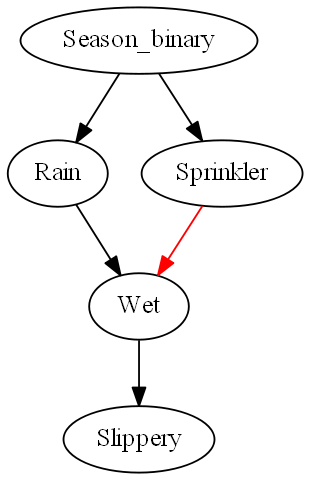

The graph is fully directed.

--------------------------------
The following present edges were forced by domain knowledge:
('Sprinkler', 'Wet')
--------------------------------
The following present edges were not forced by domain knowledge:
('Season_binary', 'Sprinkler')
('Season_binary', 'Rain')
('Rain', 'Wet')
('Wet', 'Slippery')
--------------------------------
The following missing edges were not forbidden by domain knowledge:
('Rain', 'Slippery')
('Wet', 'Rain')
('Season_binary', 'Slippery')
('Season_binary', 'Wet')
('Sprinkler', 'Slippery')
('Rain', 'Sprinkler')
('Wet', 'Sprinkler')
Saving graph to dot file.
Knowledge is respected!
Saving graph to png file.
Knowledge is respected!
Saving edge analysis.
Saving graph to svg file.
Knowledge is respected!


In [27]:
learner.run_quick_search()

The output of the search is a proposed causal graph. We can ignore the warning about stopping the Java Virtual Machine (needed by ```py-causal``` which is a wrapper around the ```TETRAD``` software that is written in Java) if we do not run into any problems. If the algorithm cannot orient all edges, we need to do this manually. Therefore, the output includes a list of all undirected edges, so we do not miss them in complicated graphs with many variables and edges. In our case, all the edges are already oriented.

The result seems reasonable:
- The weather depends on the season.
- The sprinkler use also depends on the season.
- The lawn will be wet if it rains or if the sprinkler is activated.
- The lawn will be slippery if it is wet.

### Saving the graph
```Cause2e``` allows us to save the result of our search to different file formats with the ```StructureLearner.save_graphs``` method. The name of the file is determined by the ```experiment_name``` parameter from the ```PathManager```. If the result of the graph search is already a directed acyclic graph that respects our domain knowledge, the graph is automatically saved, as we can see from the above output. Check out the graph postprocessing notebook for information on how to proceed when the result of the search needs further adjustments.

## Estimate causal effects from the graph and the data
After we have successfully recovered the causal graph from data and domain knowledge, we can use it to estimate quantitative causal effects between the variables in the graph. It is pleasant that we can use the same graph and data to estimate multiple causal effects, e.g. the one that the Sprinkler has on the lawn being slippery, as well as the one that the season has on the rain probability, without having to repeat the previous steps. Once we have managed to qualitatively model the data generating process, we are already in a very good position. The remaining challenges can be tackled with the core functionality from the ```DoWhy``` package, which we have wrapped into a single easy-to-use convenience method. Usually, all estimation topics are handled by the ```estimator.Estimator```, but the ```StructureLearner``` has the possibility to run a quick analysis of all causal effects with preset parameters. For more detailed analyses, check out the other notebooks that describe the causal identification and estimation process step by step.

Showing and saving heatmaps of the causal estimates.



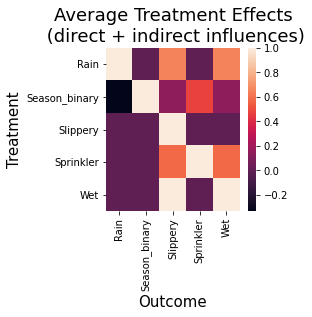

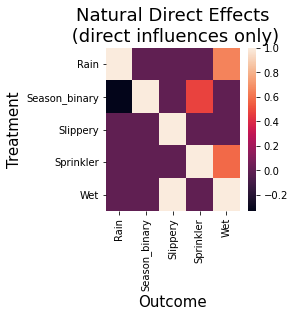

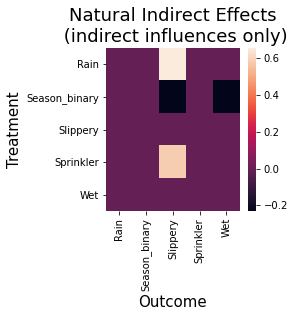

Passed validations (2/4): 
Estimated ate of Wet on Slippery: 1.00 (expected: greater than 0) -> True 
Estimated ate of Sprinkler on Wet: 0.58 (expected: greater than 0) -> True 
 
Failed validations (2/4): 
Estimated nde of Sprinkler on Rain: 0.00 (expected: less than 0) -> False 
Estimated nie of Slippery on Season_binary: 0.00 (expected: between 0.2 and 0.4) -> False 

10 Largest Average Treatment Effects
 (direct + indirect influences):
        Treatment        Outcome Estimated_effect
42            Wet       Slippery             1.00
51           Rain            Wet             0.65
57           Rain       Slippery             0.65
6       Sprinkler            Wet             0.58
12      Sprinkler       Slippery             0.58
15  Season_binary      Sprinkler             0.48
24  Season_binary           Rain            -0.33
21  Season_binary            Wet             0.15
27  Season_binary       Slippery             0.15
3       Sprinkler  Season_binary             0.00


10 L

In [28]:
learner.run_all_quick_analyses()

The output consists of a detailed analysis of the causal effects in our system.
### Heatmaps
The first three images are heatmaps, where the (i, j)-entry shows the causal effect of variable i on variable j. The three heatmaps differ in the type of causal effect that they are describing:
  - **Average Treatment Effect (ATE)**: Shows how the outcome variable varies if we vary the treatment variable. This comprises direct and indirect effects. The sprinkler influences the lawn being slippery, even if this does not happen directly, but via its influence on the lawn being wet.
  - **Natural Direct Effect (NDE)**: Shows how the outcome variable varies if we vary the treatment variable and keep all other variables fixed. This comprises only direct effects. The sprinkler does not directly influence the lawn being slippery, as we can read off from the heatmap.
  - **Natural Indirect Effect (NIE)**: Shows the difference between ATE and NDE. By definition, this comprises only indirect effects. The sprinkler has a strong indirect influence on the lawn being slippery, as we can read off from the heatmap.

In our example, we can easily identify from the graph if an effect is direct or indirect, but in examples where a variable simultaneously has a direct and an indirect influence on another variable, it is very challenging to separate the effects without resorting to the algebraic methods that ```cause2e``` uses internally.

### Validations
The next output shows if our model has passed each of the validations, based on the expected causal effects that we have communicated before running the causal end-to-end analysis. If we are interested in a specific effect, say, the effect of the sprinkler on the lawn being slippery, the estimation of this effect by our learnt causal model can be trusted more if the estimation for other effects match our expectations. We see that the results of the validations turned out exactly as described above (in practice we would not want validations to fail, this was only for demonstrative purposes).

### Numeric tables
The three numeric tables show the same information as the three previous heatmaps, only in quantitative instead of visual form.

### PDF report
```Cause2e``` automatically generates a pdf report that contains
- the causal graph indicating all qualitative relationships,
- the three heatmaps visualizing all quantitative causal effects,
- the results of the validations,
- the three numeric tables reporting all quantitative causal effects.

This is helpful if we want to communicate our findings to other people, or if we want to modify the analysis at a later time and compare the outcome for both methods.

## Discussion of the results
The heatmaps show the effects that we would expect given our causal graph: 
- There is less rain in summer than in spring.
- Sprinklers are more often turned on in summer than in spring.
- Rain increases the wetness of the lawn.
- Turning the sprinkler on also increases the wetness of the lawn.
- Wetting the lawn causes it to be slippery.

It is interesting to see that the first two effects roughly cancel each other out, resulting in a small ATE of 0.1 that ```'Season_binary'``` has on ```'Slippery'``` and ```'Wet'```. In general, it is a good strategy to look at the heatmaps for discovering the qualitative nature of the different causal effects and then inspect the numeric tables for the exact numbers if needed.

Another noteworthy entry is the overall effect of ```'Sprinkler'``` on ```'Wet'```. The result is 0.638, so turning on the sprinkler makes it more likely for the lawn to be wet, as it should be. However, we might ask ourselves: "Why is the effect not 1? Whenever we turn on the sprinkler, the lawn will be wet!" This can be explained by looking at the definition of our chosen effect type, the nonparametric average treatment effect (ATE): The ATE tells us how much (on average) we change the outcome by changing the treatment. In our case, we can distinguish between two possible scenarios:
If it is raining, then the lawn is wet anyway, so turning the sprinkler on does not change the outcome at all. Only if it is not raining, the lawn state is changed to wet by turning on the sprinkler.

We can convince ourselves that this is the correct explanation by looking at the proportion of samples where it is not raining.

In [29]:
1 - sum(learner.data['Rain']) / len(learner.data)

We recover the same number of 0.638. Additionally, we can change our data to consist only of the instances where it is not raining. If we now repeat the causal analysis, the effect is indeed 1 (skip after the warnings that are caused by the now degenerate dataset). This procedure can be generalized to analyzing other conditional causal effects.

C:\Users\D.Gruenbaum\Anaconda3\envs\test\lib\site-packages\statsmodels\regression\linear_model.py:1830: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\D.Gruenbaum\Anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\D.Gruenbaum\Anaconda3\envs\test\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\D.Gruenbaum\Anaconda3\envs\test\lib\site-packages\statsmodels\regression\linear_model.py:1774: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\D.Gruenbaum\Anaconda3\envs\test\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / no

Showing and saving heatmaps of the causal estimates.



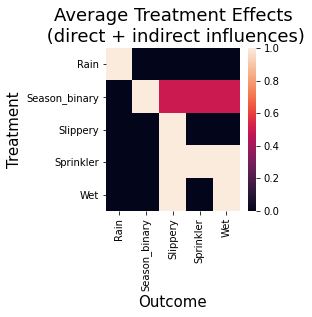

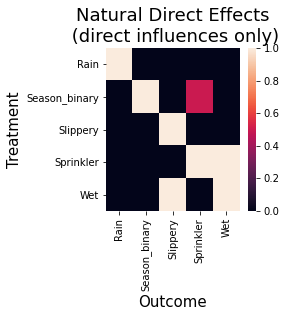

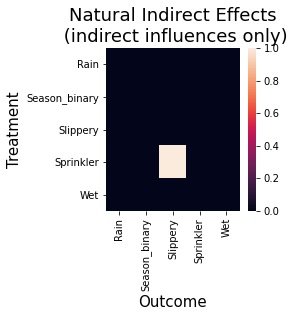

Passed validations (2/4): 
Estimated ate of Wet on Slippery: 1.00 (expected: greater than 0) -> True 
Estimated ate of Sprinkler on Wet: 1.00 (expected: greater than 0) -> True 
 
Failed validations (2/4): 
Estimated nde of Sprinkler on Rain: 0.00 (expected: less than 0) -> False 
Estimated nie of Slippery on Season_binary: 0.00 (expected: between 0.2 and 0.4) -> False 

10 Largest Average Treatment Effects
 (direct + indirect influences):
        Treatment        Outcome Estimated_effect
42            Wet       Slippery             1.00
6       Sprinkler            Wet             1.00
12      Sprinkler       Slippery             1.00
15  Season_binary      Sprinkler             0.50
21  Season_binary            Wet             0.50
27  Season_binary       Slippery             0.50
51           Rain            Wet             0.00
57           Rain       Slippery             0.00
3       Sprinkler  Season_binary             0.00
9       Sprinkler           Rain             0.00


10 L

In [30]:
learner.data = learner.data[learner.data['Rain']==0]
learner.run_all_quick_analyses()